## Demand Forecasting using AI Model


## Content
1. [Introduction](#section-intro)
2. [Importing libraries](#section-ts)
3. [Load dataset](#section-pro)
4. [Basic exploratory data analysis](#section-ten)
5. [Feature engineering](#section-ten)
6. [Data encoding](#section-ten)
7. [LightGB model](#section-ten)
8. [Time Series Analysis](#section-ten)   

## 1. Introduction

#### Dataset overview
* A warehouse chain's 5-year data includes information on 10 different warehouse and 50 different products.
* The data set covers the period between 01-01-2013 and 31-12-2017.

#### Business aim
* It is needed to create a 3-month demand forecasting model for 10 different warehouse and 50 different products of a chain of warehouses.
* Afterwards, it is needed to reduce the data set to weekly and create a demand forecasting model for 2017.

#### Variables
* date – Date of sales data (No holiday effects or store closures)
* Warehouse - ID Unique number for each wh.
* item - Item ID Unique number for each item.
* sales – Number of items sold, Number of items sold from a particular wh on a given date

## 2. Importing libraries

In [ ]:
# Importing libraries

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


import warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')



## 3. Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Диплом ВКР/AI model/aimodel_train.csv', parse_dates=['date'])
test = pd.read_csv('/content/gdrive/MyDrive/Диплом ВКР/AI model/aimodel_test.csv', parse_dates=['date'])
polyaninov_DF = pd.concat([train, test], sort=False)
polyaninov_DF = polyaninov_DF.rename(columns={'store': 'wh'})
polyaninov_DF.head()

,date,wh,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


In [ ]:
print("Size of train set",train.shape)
print("Size of test set:",test.shape)

Size of train set (913000, 4)
Size of test set: (45000, 4)


In [ ]:
#Removing the extra column 'id'
polyaninov_DF.drop(['id'],inplace=True,axis=1)
polyaninov_DF.columns

Index(['date', 'wh', 'item', 'sales'], dtype='object')

## 4. Basic exploratory data analysis

In [ ]:
#Date range
print("Date range:", polyaninov_DF["date"].min(), "to", polyaninov_DF["date"].max())
#1st Jan 2013 to 31st March, 2018

Date range: 2013-01-01 00:00:00 to 2018-03-31 00:00:00


In [ ]:
# Sales distribution

polyaninov_DF["sales"].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99])

,sales
count,913000.000000
mean,52.250287
std,28.801144
min,0.000000
10%,20.000000
30%,33.000000
50%,47.000000
70%,64.000000
80%,76.000000
90%,93.000000


In [ ]:
# Number of wh

polyaninov_DF["wh"].nunique()

10

In [ ]:
# Number of products

polyaninov_DF["item"].nunique()

50

In [ ]:
# Number of products in each wh
polyaninov_DF.groupby(["wh"])["item"].nunique()
#Every wh ahve all 50 products

,item
wh,
1,50
2,50
3,50
4,50
5,50
6,50
7,50
8,50
9,50


In [ ]:
# Sales statistics in store-product breakdown
polyaninov_DF.groupby(["wh", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
              sum       mean median        std
wh item                                       
1  1      36468.0  19.971522   19.0   6.741022
   2      97050.0  53.148959   52.0  15.005779
   3      60638.0  33.208105   33.0  10.072529
   4      36440.0  19.956188   20.0   6.640618
   5      30335.0  16.612815   16.0   5.672102
...           ...        ...    ...        ...
10 46    120601.0  66.046550   65.0  18.114991
   47     45204.0  24.755750   24.0   7.924820
   48    105570.0  57.814896   57.0  15.898538
   49     60317.0  33.032311   32.0  10.091610
   50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

## 5. Feature engineering

In [ ]:
# Generating date and time parameters from data

polyaninov_DF['month'] = polyaninov_DF.date.dt.month
polyaninov_DF['day_of_month'] = polyaninov_DF.date.dt.day
polyaninov_DF['day_of_year'] = polyaninov_DF.date.dt.dayofyear
polyaninov_DF['day_of_week'] = polyaninov_DF.date.dt.dayofweek
polyaninov_DF['year'] = polyaninov_DF.date.dt.year
polyaninov_DF["is_wknd"] = polyaninov_DF.date.dt.weekday // 4
polyaninov_DF['is_month_start'] = polyaninov_DF.date.dt.is_month_start.astype(int)
polyaninov_DF['is_month_end'] = polyaninov_DF.date.dt.is_month_end.astype(int)

In [ ]:
polyaninov_DF.head()

,date,wh,item,sales,month,day_of_month,day_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,1,2,2,2,2013,0,0,0
2,2013-01-03,1,1,14.0,1,3,3,3,2013,0,0,0
3,2013-01-04,1,1,13.0,1,4,4,4,2013,1,0,0
4,2013-01-05,1,1,10.0,1,5,5,5,2013,1,0,0


In [ ]:
# Sales statistics in wh-item-month breakdown
polyaninov_DF.groupby(["wh", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                   sum       mean median        std
wh item month                                      
1  1    1       2125.0  13.709677   13.0   4.397413
        2       2063.0  14.631206   14.0   4.668146
        3       2728.0  17.600000   17.0   4.545013
        4       3118.0  20.786667   20.0   4.894301
        5       3448.0  22.245161   22.0   6.564705
...                ...        ...    ...        ...
10 50   8      13108.0  84.567742   85.0  15.676527
        9      11831.0  78.873333   79.0  15.207423
        10     11322.0  73.045161   72.0  14.209171
        11     11549.0  76.993333   77.0  16.253651
        12      8724.0  56.283871   56.0  11.782529

[6000 rows x 4 columns]

In [ ]:
#Dealing with random noise
# For small datasets like this dataset, random noise can be added to the values ​​to prevent overfitting.
# Here I will add Gaussian random noise, which is normally distributed with 1 standard deviation and 0 mean.

def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

In [ ]:
#Lag/Shifted Features (Delays)
polyaninov_DF.sort_values(by=['wh', 'item', 'date'], axis=0, inplace=True)
polyaninov_DF.head(10)

,date,wh,item,sales,month,day_of_month,day_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,1,1,1,1,2013,0,1,0
1,2013-01-02,1,1,11.0,1,2,2,2,2013,0,0,0
2,2013-01-03,1,1,14.0,1,3,3,3,2013,0,0,0
3,2013-01-04,1,1,13.0,1,4,4,4,2013,1,0,0
4,2013-01-05,1,1,10.0,1,5,5,5,2013,1,0,0
5,2013-01-06,1,1,12.0,1,6,6,6,2013,1,0,0
6,2013-01-07,1,1,10.0,1,7,7,0,2013,0,0,0
7,2013-01-08,1,1,9.0,1,8,8,1,2013,0,0,0
8,2013-01-09,1,1,12.0,1,9,9,2,2013,0,0,0
9,2013-01-10,1,1,9.0,1,10,10,3,2013,0,0,0


In [ ]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["wh", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

polyaninov_DF = lag_features(polyaninov_DF, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [ ]:
#Moving average features
def moving_average_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["wh", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


polyaninov_DF = moving_average_features(polyaninov_DF, [365, 546, 730])


In [ ]:
#Exponentially Weighted Average Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["wh", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

polyaninov_DF = ewm_features(polyaninov_DF, alphas, lags)

## 6. Data encoding

In [ ]:
#Checking for null values
polyaninov_DF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 958000 entries, 0 to 44999
Data columns (total 79 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   date                         958000 non-null  datetime64[ns]
 1   wh                           958000 non-null  int64         
 2   item                         958000 non-null  int64         
 3   sales                        913000 non-null  float64       
 4   month                        958000 non-null  int32         
 5   day_of_month                 958000 non-null  int32         
 6   day_of_year                  958000 non-null  int32         
 7   day_of_week                  958000 non-null  int32         
 8   year                         958000 non-null  int32         
 9   is_wknd                      958000 non-null  int32         
 10  is_month_start               958000 non-null  int64         
 11  is_month_end                 958

In [ ]:
#One-Hot Encoding
polyaninov_DF = pd.get_dummies(polyaninov_DF, columns=['day_of_week', 'month'])

In [ ]:
#Converting sales to log(1+sales)
polyaninov_DF['sales'] = np.log1p(polyaninov_DF["sales"].values)

## 7. LightGBM model

In [ ]:
# Train data set until the beginning of 2017 (end of 2016)
train = polyaninov_DF.loc[(polyaninov_DF["date"] < "2017-01-01"), :]

# First 3 months of 2017 validation set
val = polyaninov_DF.loc[(polyaninov_DF["date"] >= "2017-01-01") & (polyaninov_DF["date"] < "2017-04-01"), :]

# Independent variables
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [ ]:
# Selecting the dependent variable for the train set
Y_train = train['sales']

# Selecting the argument for the train set
X_train = train[cols]

# choosing the dependent variable for the validation set
Y_val = val['sales']

# selecting the independent variable for the validation set
X_val = val[cols]

# Checking the shapes
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 93), (45000,), (45000, 93))

In [ ]:
# Custom Cost Function

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False


In [ ]:
# Custom MAPE Function
def mape(preds, target):
    n = len(preds)
    masked_arr = target != 0
    preds, target = preds[masked_arr], target[masked_arr]
    mape_val = (np.abs((target - preds) / target)).sum() * 100 / n
    return mape_val

def lgbm_mape(preds, train_data):
    labels = train_data.get_label()
    mape_val = mape(np.expm1(preds), np.expm1(labels))
    return 'MAPE', mape_val, False


In [ ]:
# Custom RMSE Function
def rmse(preds, target):
    n = len(preds)
    mse = np.mean((preds - target) ** 2)
    return np.sqrt(mse)

def lgbm_rmse(preds, train_data):
    labels = train_data.get_label()
    rmse_val = rmse(np.expm1(preds), np.expm1(labels))
    return 'RMSE', rmse_val, False

In [ ]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

In [ ]:
common_cols = X_train.columns.intersection(X_val.columns)
X_train = X_train[common_cols]
X_val = X_val[common_cols]

In [ ]:
# Ensure columns are aligned
X_val = X_val[X_train.columns]

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=list(X_train.columns))
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=list(X_val.columns))

model = lgb.train(
    lgb_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=lgb_params['num_boost_round'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=100)
    ],
    feval=[lgbm_mape, lgbm_rmse]
)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

print("MAPE:", mape(np.expm1(y_pred_val), np.expm1(Y_val)))
print("RMSE:", rmse(np.expm1(y_pred_val), np.expm1(Y_val)))

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

**The best MAPE is 37.03224772470711. The best RMSE is 20.279020357164573**

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  callbacks=[
        lgb.early_stopping(stopping_rounds=lgb_params['early_stopping_rounds']),
        lgb.log_evaluation(period=100)  # this replaces verbose_eval
    ],
    feval=lgbm_smape)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# percentage of validation error
smape(np.expm1(y_pred_val), np.expm1(Y_val))

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.171522	training's SMAPE: 17.4946	valid_1's l1: 0.171542	valid_1's SMAPE: 17.5332
[200]	training's l1: 0.141246	training's SMAPE: 14.4675	valid_1's l1: 0.145121	valid_1's SMAPE: 14.8876
[300]	training's l1: 0.135646	training's SMAPE: 13.9065	valid_1's l1: 0.139988	valid_1's SMAPE: 14.3723
[400]	training's l1: 0.13363	training's SMAPE: 13.7052	valid_1's l1: 0.13835	valid_1's SMAPE: 14.2084
[500]	training's l1: 0.132424	training's SMAPE: 13.5844	valid_1's l1: 0.137047	valid_1's SMAPE: 14.0776
[600]	training's l1: 0.131617	training's SMAPE: 13.5034	valid_1's l1: 0.136138	valid_1's SMAPE: 13.9861
[700]	training's l1: 0.131013	training's SMAPE: 13.4428	valid_1's l1: 0.135411	valid_1's SMAPE: 13.9129
[800]	training's l1: 0.130517	training's SMAPE: 13.3933	valid_1's l1: 0.134913	valid_1's SMAPE: 13.8627
[900]	training's l1: 0.130103	training's SMAPE: 13.3517	valid_1's l1: 0.134554	valid_1's SMAPE: 13.8265
[100

np.float64(13.492770113335824)

**The best SMAPE is 13.492770113335824**

### Final SMAPE Model

In [ ]:
# determination of test and train dependent/independent variables

train = polyaninov_DF.loc[~polyaninov_DF.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

test = polyaninov_DF.loc[polyaninov_DF.sales.isna()]
X_test = test[cols]

In [ ]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)

Final and best SMAPE is 13.492770113335824

## 8. Time Series Analysis

* In this section, first of all, the train data set will be reduced to a weekly basis.
* Then, using the weekly data set, respectively:
* LightGBM model
* Single exponential smoothing
* Double exponential smoothing
* Triple exponential smoothing
* ARIMA
* Sales demand forecasting models for 2017 will be created with SARIMA.
* Actual values ​​will be compared with estimated values.


### Load Dataset and EDA

In [ ]:
tsa_data = pd.read_csv('/content/gdrive/MyDrive/Диплом ВКР/AI model/aimodel_train.csv', parse_dates=['date'])
tsa_data.head()
tsa_data.shape

# reduce dataset to weekly
tsa_data.set_index("date",inplace=True)
tsa_df= tsa_data.resample("W").mean()
tsa_df.reset_index(inplace=True)
tsa_df.head()
tsa_df.shape

tsa_df.index.freq = "W"
tsa_df.head()

,date,store,item,sales
0,2013-01-06,5.5,25.5,30.355667
1,2013-01-13,5.5,25.5,29.686286
2,2013-01-20,5.5,25.5,29.414286
3,2013-01-27,5.5,25.5,29.513714
4,2013-02-03,5.5,25.5,31.150571


In [ ]:
tsa_df.shape

(261, 4)

### Feature engineering

In [ ]:
# Month
tsa_df['month'] = tsa_df.date.dt.month
# Day of Month
tsa_df['day_of_month'] = tsa_df.date.dt.day
# Day of year
tsa_df['day_of_year'] = tsa_df.date.dt.dayofyear
# Day of week
tsa_df['day_of_week'] = tsa_df.date.dt.dayofweek
# Year
tsa_df['year'] = tsa_df.date.dt.year
# Weekend check
tsa_df["is_wknd"] = tsa_df.date.dt.weekday // 4
# Month start check
tsa_df['is_month_start'] = tsa_df.date.dt.is_month_start.astype(int)
# Month end check
tsa_df['is_month_end'] = tsa_df.date.dt.is_month_end.astype(int)

# Lag/Shifted Features (Delays)
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

tsa_df = lag_features(tsa_df, [31, 61, 91, 98, 105, 112])


# Moving Average Features
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


tsa_df = roll_mean_features(tsa_df, [31, 61, 91, 98, 105, 112])


# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe


alphas = [0.99, 0.95, 0.9, 0.8, 0.7, 0.5]
lags = [10, 20, 30, 40, 50]

tsa_df = ewm_features(tsa_df, alphas, lags)

tsa_df.tail()


,date,store,item,sales,month,day_of_month,day_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,sales_lag_31,sales_lag_61,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_roll_mean_31,sales_roll_mean_61,sales_roll_mean_91,sales_roll_mean_98,sales_roll_mean_105,sales_roll_mean_112,sales_ewm_alpha_099_lag_10,sales_ewm_alpha_099_lag_20,sales_ewm_alpha_099_lag_30,sales_ewm_alpha_099_lag_40,sales_ewm_alpha_099_lag_50,sales_ewm_alpha_095_lag_10,sales_ewm_alpha_095_lag_20,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_40,sales_ewm_alpha_095_lag_50,sales_ewm_alpha_09_lag_10,sales_ewm_alpha_09_lag_20,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_40,sales_ewm_alpha_09_lag_50,sales_ewm_alpha_08_lag_10,sales_ewm_alpha_08_lag_20,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_40,sales_ewm_alpha_08_lag_50,sales_ewm_alpha_07_lag_10,sales_ewm_alpha_07_lag_20,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_40,sales_ewm_alpha_07_lag_50,sales_ewm_alpha_05_lag_10,sales_ewm_alpha_05_lag_20,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_40,sales_ewm_alpha_05_lag_50
256,2017-12-03,5.5,25.5,53.510286,12,3,337,6,2017,1,0,0,62.609893,56.247228,50.264224,35.979766,55.449226,52.082399,64.634993,61.509448,55.658521,57.357548,56.406205,56.124525,61.944343,75.326579,66.655854,44.464902,42.682299,61.949367,75.308760,66.468077,44.460477,42.696424,61.957303,75.273841,66.233661,44.454102,42.750531,61.987351,75.156915,65.763164,44.431749,43.010549,62.055540,74.967582,65.279091,44.379961,43.525509,62.454476,74.293534,64.107567,44.083539,45.549427
257,2017-12-10,5.5,25.5,44.114286,12,10,344,6,2017,1,0,0,64.101374,56.102305,51.916356,39.470526,40.092499,50.963247,65.383920,62.361108,59.131620,57.479455,56.417432,57.899422,61.176895,75.422743,66.631673,50.817829,42.680306,61.208154,75.417967,66.623261,50.560924,42.681093,61.247959,75.408727,66.591652,50.239210,42.687310,61.332784,75.370354,66.457776,49.591950,42.746338,61.435062,75.286875,66.225727,48.931388,42.933853,61.811809,74.858624,65.369498,47.482770,44.114856
258,2017-12-17,5.5,25.5,44.370286,12,17,351,6,2017,1,0,0,64.126541,58.002215,51.551498,38.889284,37.850656,52.684360,62.497049,60.384660,58.412186,55.945447,58.817459,55.811019,57.585703,75.263325,66.745140,53.133184,41.904974,57.732365,75.269527,66.740134,53.026789,41.936340,57.919282,75.276416,66.730822,52.864835,41.976160,58.306100,75.283442,66.688584,52.443647,42.066982,58.715119,75.269262,66.590118,51.889017,42.208156,59.680619,75.060169,66.057892,50.319670,43.005999
259,2017-12-24,5.5,25.5,44.423429,12,24,358,6,2017,1,0,0,68.588930,56.737182,52.228990,45.037038,40.248428,51.778576,62.777804,61.297534,56.383206,58.583646,59.037383,59.189170,57.708474,67.553308,66.586743,53.126072,40.050730,57.710847,67.865133,66.592892,53.121039,40.127217,57.730671,68.255527,66.599711,53.099884,40.226416,57.828991,69.037031,66.605831,52.989529,40.438996,58.011336,69.813579,66.586635,52.754905,40.684847,58.695167,71.267799,66.321517,51.722835,41.519000
260,2017-12-31,5.5,25.5,44.417429,12,31,365,6,2017,1,0,1,65.870512,53.517713,56.528931,43.254016,42.226244,57.702978,66.299410,61.050937,57.875777,56.524607,61.488526,58.579896,57.943342,66.656487,68.985485,53.177198,39.972504,57.933971,66.708314,68.888873,53.174881,39.979489,57.924210,66.808238,68.768714,53.169931,39.997184,57.922370,67.125349,68.528938,53.140077,40.065171,57.965401,67.597274,68.282791,53.050871,40.185654,58.320440,68.957614,67.665616,52.450275,40.745357


### LightGBM Model

In [ ]:
# One-Hot Encoding
tsa_df = pd.get_dummies(tsa_df, columns=['day_of_week', 'month'])

# Converting sales to log(1+sales)
tsa_df['sales'] = np.log1p(tsa_df["sales"].values)

# train-test data selection
train = tsa_df.loc[(tsa_df["date"] < "2017-01-01"), :]
test = tsa_df.loc[(tsa_df["date"] >= "2017-01-01"), :]

# Dependent and Independent variables
cols = [col for col in train.columns if col not in ['date', "sales", "year"]]
X_train = train[cols]
Y_train = train['sales']
X_test = test[cols]
Y_test = test["sales"]


In [ ]:
# LightGBM parameters
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_test, label=Y_test, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  callbacks=[
        lgb.early_stopping(stopping_rounds=lgb_params['early_stopping_rounds']),
        lgb.log_evaluation(period=100)  # this replaces verbose_eval
    ],
    feval=lgbm_smape)

y_pred_test = model.predict(X_test, num_iteration=model.best_iteration)

# percentage of test error
smape(np.expm1(y_pred_test), np.expm1(Y_test))


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 200 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

np.float64(3.651111442081807)

### Feature importance

                       feature  split       gain
48   sales_ewm_alpha_05_lag_50    228  49.480475
3                  day_of_year    961  14.514013
43   sales_ewm_alpha_07_lag_50     99  13.366069
14          sales_roll_mean_61    119   3.681198
11               sales_lag_105    217   2.912985
38   sales_ewm_alpha_08_lag_50     99   1.941236
44   sales_ewm_alpha_05_lag_10    117   1.688360
19  sales_ewm_alpha_099_lag_10    151   1.458968
22  sales_ewm_alpha_099_lag_40    182   1.185214
20  sales_ewm_alpha_099_lag_20    130   1.175707
33   sales_ewm_alpha_09_lag_50     39   0.943426
13          sales_roll_mean_31    159   0.913132
40   sales_ewm_alpha_07_lag_20    107   0.796396
21  sales_ewm_alpha_099_lag_30    177   0.532926
2                 day_of_month    505   0.527284
7                 sales_lag_31    189   0.469947
24  sales_ewm_alpha_095_lag_10    154   0.441885
45   sales_ewm_alpha_05_lag_20    154   0.403730
27  sales_ewm_alpha_095_lag_40     48   0.299856
34   sales_ewm_alpha

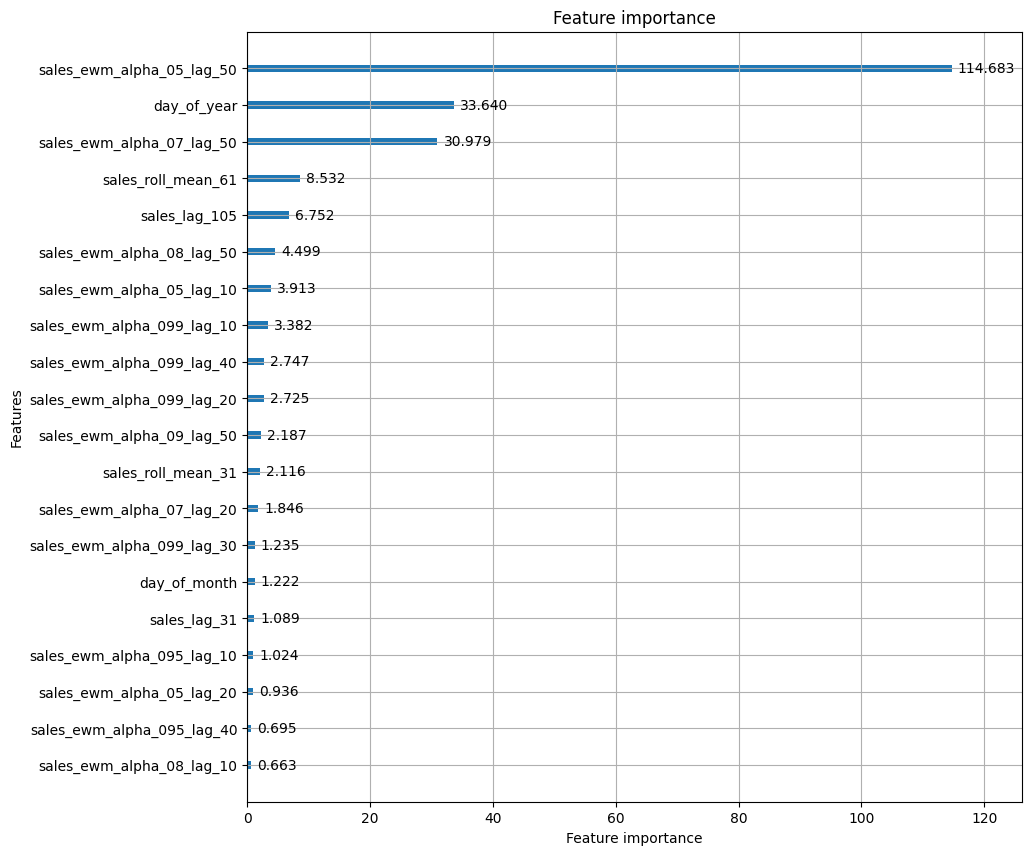

In [ ]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))


plot_lgb_importances(model, num=30)
#plot_lgb_importances(model, num=30, plot=True)

lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()


In [ ]:
# Final model

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = model.predict(X_test, num_iteration=model.best_iteration)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

The best SMAPE of TSA is 3.651111442081807

## The prediction

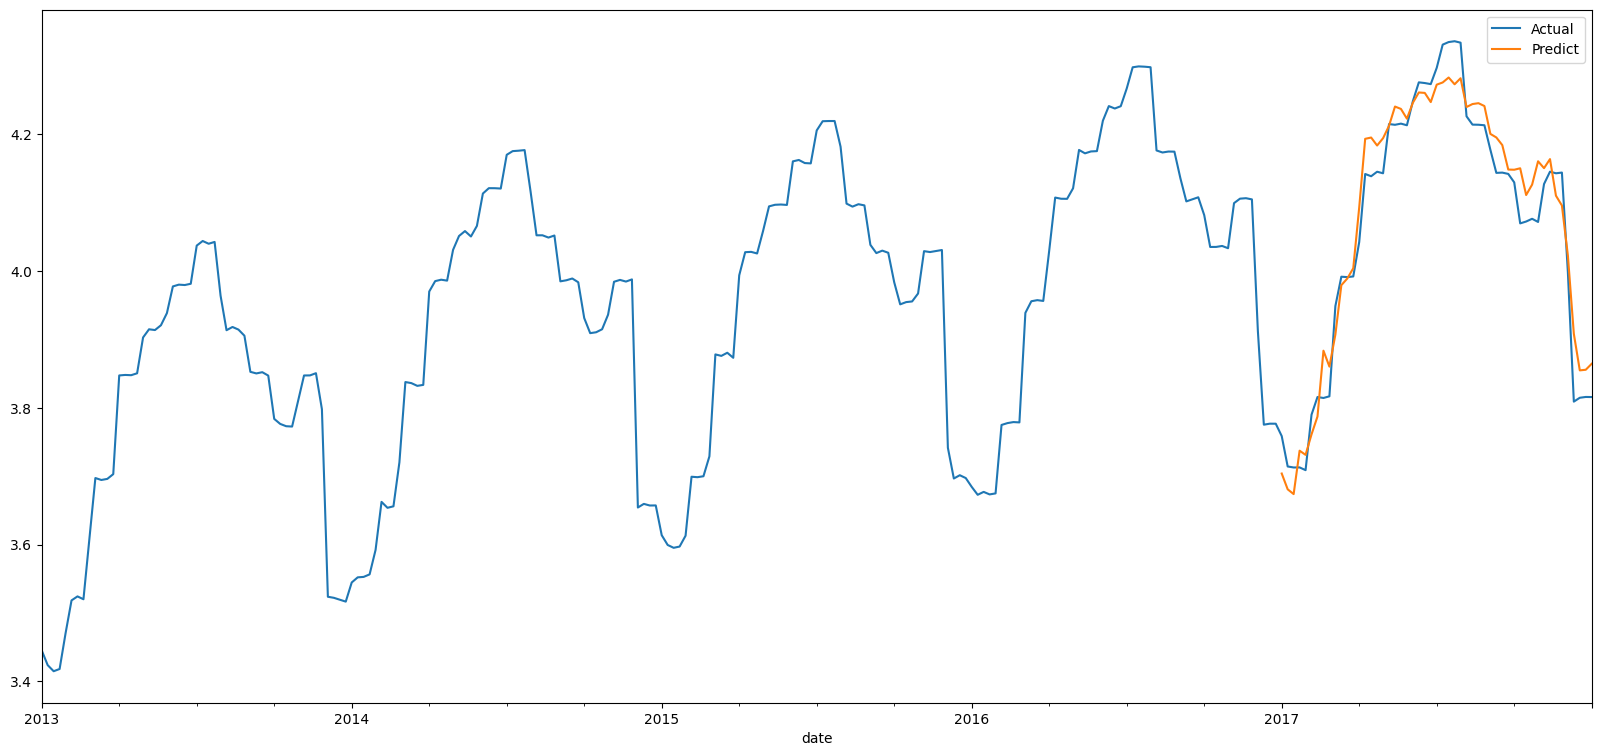

In [ ]:
# 1 year actual and predicted values
forecast = pd.DataFrame({"date":test["date"],
                        "store":test["store"],
                        "item":test["item"],
                        "sales":test_preds
                        })

tsa_df.set_index("date").sales.plot(figsize = (20,9),legend=True, label = "Actual")
forecast.set_index("date").sales.plot(legend=True, label = "Predict")
plt.show()